In [16]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns

In [17]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0_panoptic.yaml'])
cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)
frame_reader = get_dataset(cfg, args, cfg["scale"], slam = slam)
frame_reader.__post_init__(slam)
zero_pos = frame_reader.poses[0]
zero_pos

INFO: The output folder is output/Own/room0_panoptic
INFO: The GT, generated and residual depth/color images can be found under output/Own/room0_panoptic/mapping_vis/
INFO: The mesh can be found under output/Own/room0_panoptic/mesh/
INFO: The checkpoint can be found under output/Own/room0_panoptic/ckpt/


tensor([[-0.3364, -0.0560,  0.9401,  1.2005],
        [ 0.9417, -0.0200,  0.3358,  0.2936],
        [ 0.0000,  0.9982,  0.0595,  1.1662],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [24]:
class Segmenter(object):

    def __init__(self, slam, cfg, args, zero_pos, store_directory):
        self.store_directory = store_directory
        self.zero_pos = zero_pos
        os.makedirs(f"{store_directory}", exist_ok=True)

        s = torch.ones((4, 4)).int()
        if cfg["dataset"] == "tumrgbd":
            #s[[0, 0, 1, 2], [0, 1, 2, 2]] *= -1
            s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        if cfg["dataset"] == "replica":
            s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        self.shift = s.numpy()  # s
        self.is_full_slam = cfg["Segmenter"]["full_slam"]
        self.store_vis = cfg["Segmenter"]["store_vis"]
        self.use_stored = cfg["Segmenter"]["use_stored"]
        self.first_min_area = cfg["mapping"]["first_min_area"]

        """path_to_traj = cfg["data"]["input_folder"] + "/traj.txt"
        self.T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
        self.T_wc[:, 1:3] *= -1"""

        self.every_frame = cfg["mapping"]["every_frame"]
        # self.slam = slam
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        #self.estimate_c2w_list = slam.estimate_c2w_list
        #self.idx_coarse_mapper = slam.idx_coarse_mapper

        self.every_frame_seg = cfg["Segmenter"]["every_frame"]
        self.points_per_instance = cfg["mapping"]["points_per_instance"]
        '''self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            slam.H, slam.W, slam.fx, slam.fy, slam.cx, slam.cy
        )'''
        self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            cfg["cam"]["H"],
            cfg["cam"]["W"],
            cfg["cam"]["fx"],
            cfg["cam"]["fy"],
            cfg["cam"]["cx"],
            cfg["cam"]["cy"],
        )
        self.cfg = cfg
        self.update_cam()
        self.K = as_intrinsics_matrix([self.fx, self.fy, self.cx, self.cy])
        
        if args is None or args.input_folder is None:
            self.input_folder = cfg["data"]["input_folder"]
        else:
            self.input_folder = args.input_folder
        #self.color_paths = sorted(glob.glob(f"{self.input_folder}/results/frame*.jpg"))
        # self.depth_paths = sorted(glob.glob(f"{self.input_folder}/results/depth*.png"))
        self.frame_reader = get_dataset(
            cfg,
            args,
            cfg["scale"],
            device=cfg["mapping"]["device"],
            tracker=False,
            slam=slam,
        )
        self.estimate_c2w_list = np.concatenate([p[None] for p in self.frame_reader.poses], axis=0)
        """for i in range(len(self.estimate_c2w_list)):
            self.estimate_c2w_list[i, :3,:3] = self.estimate_c2w_list[i, :3,:3].T 
            self.estimate_c2w_list[i, :3, 3] = np.matmul(-self.estimate_c2w_list[i, :3,:3], self.estimate_c2w_list[i, :3, 3])
        print(self.estimate_c2w_list.shape)"""
        print(self.estimate_c2w_list.shape)
        print(f'est list: {self.estimate_c2w_list[0]}')
        self.n_img = self.frame_reader.n_img
        self.semantic_frames = slam.semantic_frames
        self.idx_segmenter = slam.idx_segmenter
        if not self.is_full_slam:
            self.idx = torch.tensor([self.n_img])
        else:
            self.idx = slam.idx  # Tracking index
            # Segmenter index
        # self.new_id = 0
        self.visualizer = vis.visualizerForIds()
        self.frame_numbers = []
        self.samples = None
        self.deleted = {}
        self.border = 0 
        '''(
            cfg["cam"]["crop_edge"]
            if "crop_edge" in cfg["cam"]
            else cfg["Segmenter"]["border"]
        )'''
        self.num_clusters = cfg["Segmenter"]["num_clusters"]
        self.overlap = cfg["Segmenter"]["overlap"]
        self.relevant = cfg["Segmenter"]["relevant"]
        self.max_id = 0
        self.update = {}
        self.verbose = cfg["Segmenter"]["verbose"]
        self.merging_parameter = cfg["Segmenter"]["merging_parameter"]
        self.hit_percent = cfg["Segmenter"]["hit_percent"]

    def update_cam(self):
        """
        Update the camera intrinsics according to pre-processing config,
        such as resize or edge crop.
        """
        # resize the input images to crop_size (variable name used in lietorch)
        if "crop_size" in self.cfg["cam"]:
            crop_size = self.cfg["cam"]["crop_size"]
            sx = crop_size[1] / self.W
            sy = crop_size[0] / self.H
            self.fx = sx * self.fx
            self.fy = sy * self.fy
            self.cx = sx * self.cx
            self.cy = sy * self.cy
            self.W = crop_size[1]
            self.H = crop_size[0]

        # croping will change H, W, cx, cy, so need to change here
        if self.cfg["cam"]["crop_edge"] > 0:
            self.H -= self.cfg["cam"]["crop_edge"] * 2
            self.W -= self.cfg["cam"]["crop_edge"] * 2
            self.cx -= self.cfg["cam"]["crop_edge"]
            self.cy -= self.cfg["cam"]["crop_edge"]

    def segment_idx_forAuto(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        #gt_color_np = np.clip(img.cpu().numpy(), 0, 1)
        """plt.imshow(gt_color_np)
        plt.title(f'color {idx}')
        plt.show()"""
        img = (img.cpu().numpy() * 255).astype(np.uint8)
        masksCreated, s, max_id = id_generation.createFrontMappingAutosort(
            idx,
            self.estimate_c2w_list*self.shift,
            self.K,
            depth.cpu(),
            self.predictor,
            max_id=self.max_id,
            current_frame=img,
            samples=self.samples,
            smallesMaskSize=1000,
            border=self.border
        )
        #s[2] *= -1
        self.samples = s
        self.max_id = max_id

        frame = torch.from_numpy(masksCreated)
        self.semantic_frames[idx // self.every_frame_seg] = frame
        return frame

    def segment_first_ForAuto(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        sns.histplot(depth.cpu().numpy().reshape(-1), bins=100)
        plt.title('depth 0')
        plt.show()
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam_forauto("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()

        ids = backproject.generateIds_Auto(masks,depth.cpu(), min_area=self.first_min_area)
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        ids[depth.cpu() == 0] = -100
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max() + 1
        
        samplesFromCurrent = backproject.sample_from_instances_with_ids_area(
            ids, self.max_id, points_per_instance=500
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.zero_pos*self.shift,
            self.K,
            depth.cpu(),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        return realWorldSamples

    def runAuto(self, max=-1):
        visualizerForId = vis.visualizerForIds()

        print("segment first frame")
        s = self.segment_first_ForAuto()
        #print("finished segmenting first frame")
        visualizerForId.visualize(self.semantic_frames[0], path = 'test/00_after.png')
        im = visualizerForId.visualize(self.semantic_frames[0])
        plt.show()
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        #s[2] *= -1
        self.samples = s
        #self.samples = np.array([[0,0,1],[0,1,0],[1,0,0], [0,0,0]])
        print(np.unique(self.samples[3], return_counts=True))
        self.predictor = create_instance_seg.create_sam_forauto("cuda")
   
        index_frames = np.arange(
            self.every_frame_seg, self.n_img, self.every_frame_seg
        )
          
        self.plot()
        for idx in index_frames: #tqdm(index_frames, desc="Segmenting frames"):
            if idx == 200:
                #self.plot_mesh()
                return
            #print("start segmenting frame: ", idx)
            start = time.time()
            self.segment_idx_forAuto(idx)
            print(f'time: {time.time()-start}')
            print(np.unique(self.samples[3], return_counts=True))
            frame = self.semantic_frames[idx // self.every_frame_seg]
            #print("finished segmenting frame: ", idx)
            #fig, ax = plt.subplots(1)

            visualizerForId.visualize(
                frame.cpu().numpy()
            )
            plt.title(f"frame: {idx}")
            #ax[1].imshow(self.frame_reader.get_colorAndDepth(idx)[1].cpu().numpy())
            plt.show()
            self.plot()
            """_,depth= frame_reader.get_colorAndDepth(idx)
            sns.heatmap(depth.cpu().numpy() == 0)
            plt.show()"""
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            _ = self.segment_idx_forAuto(self.n_img - 1)


        return self.semantic_frames, self.max_id + 1
    
    def plot_mesh(self):
        import open3d as o3d
        data = self.samples.copy()[:3].T
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data)
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

        # Step 2: Compute a mesh using the Ball Pivoting algorithm
        # You may need to adjust the radii parameter based on the scale of your point cloud
        radii = [1,1,1,1]
        mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
            pcd, o3d.utility.DoubleVector(radii))

        # Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
        mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
        o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

        plt.show()
    
    def plot(self):
        data = self.samples.copy()
        #data = data[:, data[1] > -2]
        data = self.samples.copy()
        #data = data[:, data[1] > -2]
        x = data[0]
        y = data[1]
        z = data[2] * -1
        labels = data[3]

        # Create a scatter plot
        fig = plt.figure()
        fig.set_size_inches(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d")
        ax = fig.add_subplot(111, projection="3d")

        # Plot each point with a color corresponding to its label
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)
            ax.scatter(x[indices], y[indices], z[indices], s=3)

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        #ax.set_ylim((-2, 2))
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        #ax.set_ylim((-2, 2))
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()
    
    def debugging(self):
        poses = self.estimate_c2w_list
        ff_pos = np.array([[0,1,30,300],[1,0,30,300]])
        print(ff_pos.T)
        depth = frame_reader.get_colorAndDepth(20)[1].cpu()
        ff_rw = backproject.realWorldProject(ff_pos, poses[20], self.K, depth)
        print(ff_rw)
        cam = backproject.camProject(ff_rw, poses[20], self.K)[0].T
        print(cam)
        """rw_pos = np.array([[100,0,0],[0,0,100],[0,100,0]])
        poses = self.estimate_c2w_list
        print(ff_pos)
        
        plt.imshow(depth)
        plt.show()
        ff_rw = backproject.realWorldProject(ff_pos, poses[0], self.K, depth)
        print(ff_rw)
        cam = backproject.camProject(rw_pos, poses[20], self.K)[0].T
        print(cam)
        plt.scatter(cam[:,0], cam[:,1])
        plt.show()"""

In [25]:
frame_reader.get_colorAndDepth(0)[1].shape

torch.Size([324, 584])

In [26]:
segmenter = Segmenter(slam, cfg, args, zero_pos, 'test')

(900, 4, 4)
est list: [[-0.33638352 -0.05601911  0.94005746  1.2004606 ]
 [ 0.9417251  -0.02000999  0.33578783  0.29362085]
 [ 0.          0.99822915  0.05948563  1.1661639 ]
 [ 0.          0.          0.          1.        ]]


In [27]:
segmenter.debugging()

[[  0   1]
 [  1   0]
 [ 30  30]
 [300 300]]
[[17.30489281 17.34634998 19.7007435   8.56412666]
 [-6.67211678 -6.65481727 -6.62744401  3.17016996]
 [-6.8203241  -6.90069858 -6.43767428  6.6602801 ]]
[[  0   1]
 [  1   0]
 [ 30  30]
 [299 299]]


In [28]:
import os
import shutil

folder_path = '/home/rozenberszki/project/wsnsl/test'

# Check if the folder exists
if os.path.exists(folder_path):
    # Delete the folder and its contents
    shutil.rmtree(folder_path)

# Create the folder
os.makedirs(folder_path)


segment first frame


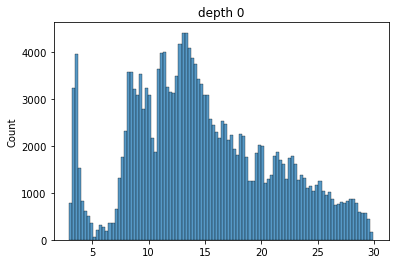

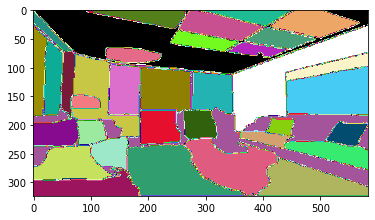

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34.]), array([871, 587, 443, 281, 401, 376, 299, 243, 230, 220, 186, 183, 178,
       177, 162, 150, 139, 132, 127, 118, 112, 109, 106, 103,  98,  94,
        85,  83,  82,  73,  62,  61,  48,  44,  43]))


No handles with labels found to put in legend.


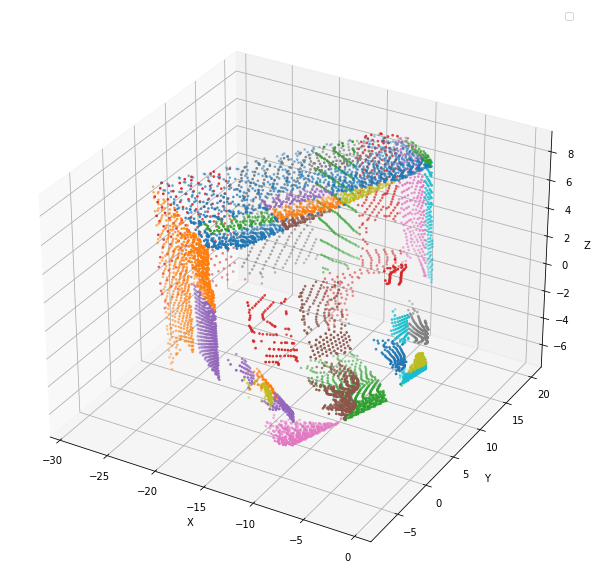

mask generation time:  0.7277798652648926
time: 23.941110849380493
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56.]), array([1449,  587,  443,  281,  964, 1633,  299,  243,  595,  220,  186,
        183,  178,  177,  607,  284,  139,  264,  127,  118,  112,  109,
        106,  103,   98,   94,   85,   83,   82,   73,   62,   61,   48,
         44,   43,  877,  183,  196,  236,  218,  177,  176,  140,  127,
        106,   99,   93,   89,   69,   64,   61,   60,   59,   58,   48,
         46,   42]))


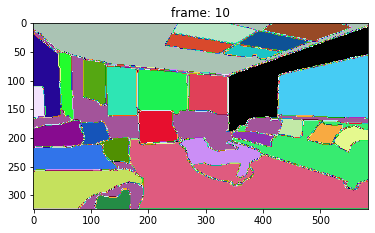

No handles with labels found to put in legend.


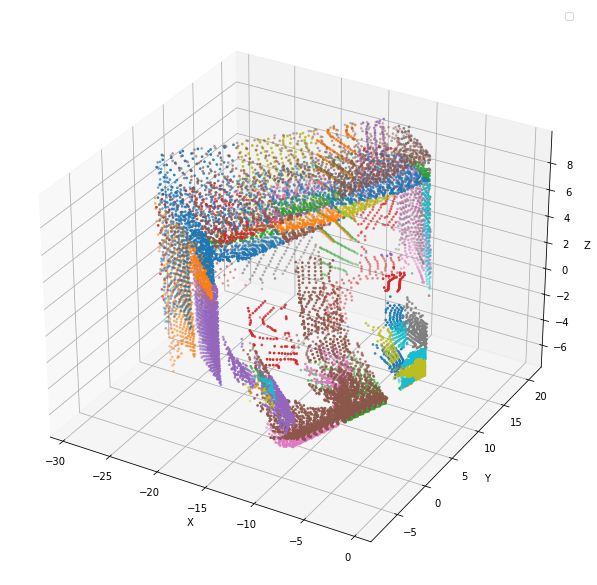

mask generation time:  0.7473292350769043
time: 34.337284564971924
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74.]), array([1449,  587,  443,  352,  964, 2967,  299,  243,  595,  283,  186,
        183,  178,  177, 1100,  400,  139,  264,  127,  118,  112,  109,
        106,  103,   98,   94,   85,   83,   82,   73,   62,   61,   48,
         44,   43, 1164,  396,  196,  236,  672,  580,  176,  140,  127,
        106,   99,   93,   89,   69,  121,  206,   60,  111,   58,   48,
         46,   42,  718,  533,  165,  157,  108,  106,  105,   98,   80,
         69,   66,   65,   62,   51,   48,   47,   46,   44]))


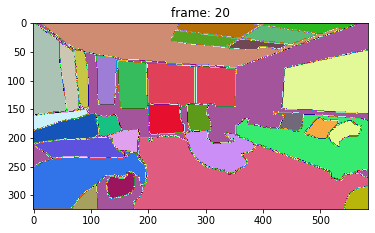

No handles with labels found to put in legend.


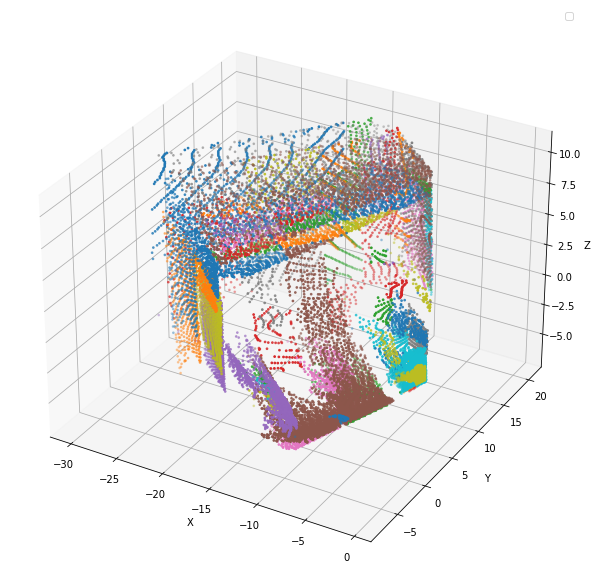

mask generation time:  0.8182268142700195
time: 59.935778856277466
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86.]), array([1449,  921,  443,  446,  964, 4217,  299,  243,  595,  283,  186,
        183,  178,  177, 1481,  503,  139,  355,  127,  118,  535,  109,
        106,  219,   98,   94,   85,   83,  186,   73,   62,   61,   48,
         44,   43, 1628,  396,  196,  236,  672,  971,  176,  140,  127,
        191,   99,   93,   89,   69,  174,  338,   60,  159,   58,   48,
         46,   42, 1539,  533,  165,  157,  108,  106,  217,   98,  148,
        

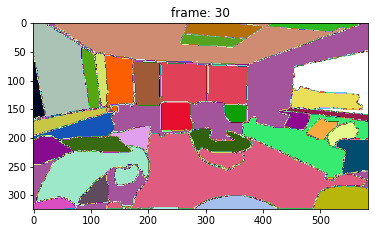

No handles with labels found to put in legend.


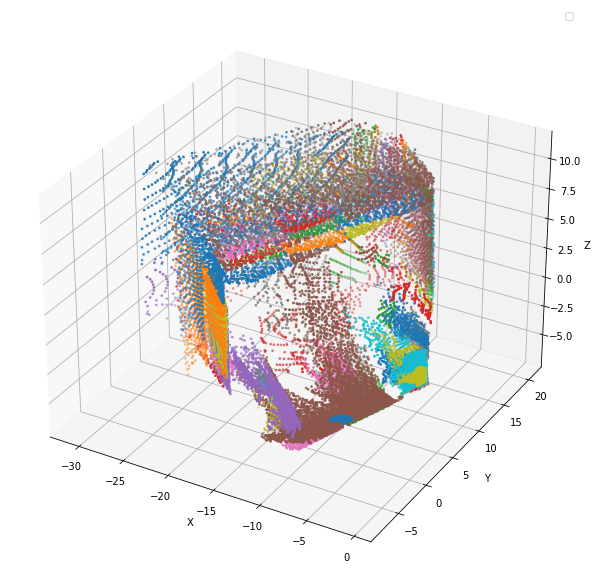

mask generation time:  0.7484283447265625
time: 60.55371570587158
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94.]), array([2098, 1008, 1645,  570,  964, 4217,  299,  243,  595,  283,  186,
        183,  178,  177, 2007,  503,  139,  436,  127,  118,  607,  109,
        106,  313,   98,   94,   85,   83,  186,   73,   62,   61,   48,
         44,   43, 2634,  396,  196,  236,  672, 1349,  176,  239,  235,
        191,   99,   93,   89,  338,  225,  338,   60,  204,   58,   48,
         46,   42, 1539,  533,  165

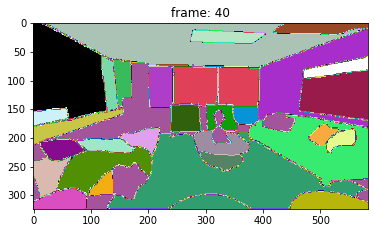

No handles with labels found to put in legend.


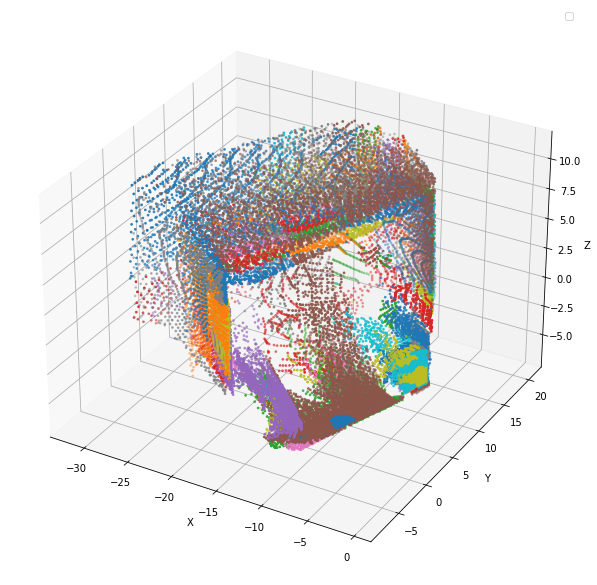

mask generation time:  0.7785923480987549
time: 57.28952121734619
(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106.]), array([2563, 1008, 2770, 1060,  964, 4217,  299,  243,  595,  283,  330,
        183,  178,  177, 2378,  570,  139,  496,  127,  118,  825,  109,
        106,  402,   98,   94,   85,   83,  186,   73,   62,   61,   48,


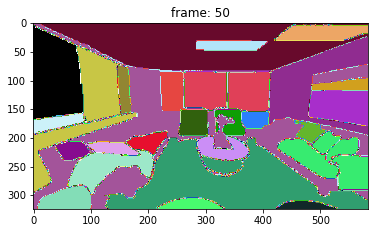

No handles with labels found to put in legend.


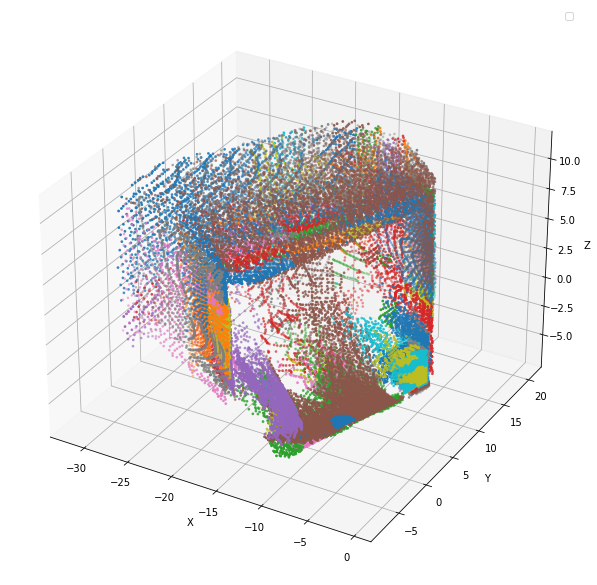

mask generation time:  0.7575314044952393
time: 65.45570015907288
(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117.]), array([4436, 1008, 3758, 1290,  964, 4496,  299,  243,  595,  283,  330,
        263,  178,  177, 2698,  570,  139,  548,  127,  118,  825,  109,


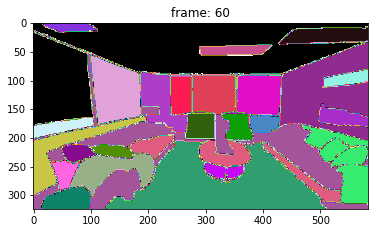

No handles with labels found to put in legend.


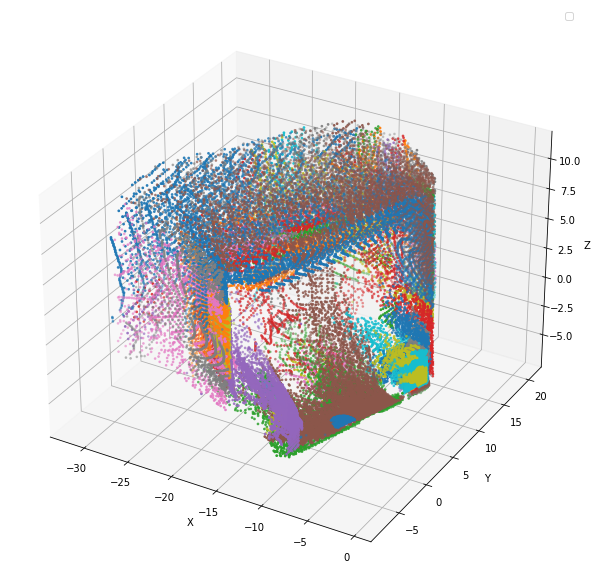

mask generation time:  0.7563979625701904
time: 67.0146996974945
(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121.]), array([6240, 1008, 4735, 1485,  964, 4793,  299,  243,  595,  283,  447,
        358,  178,  177, 2941,  570,  139, 

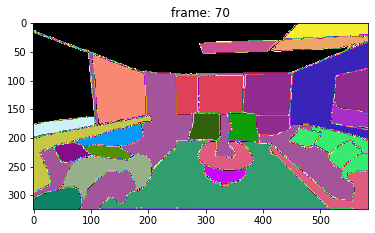

No handles with labels found to put in legend.


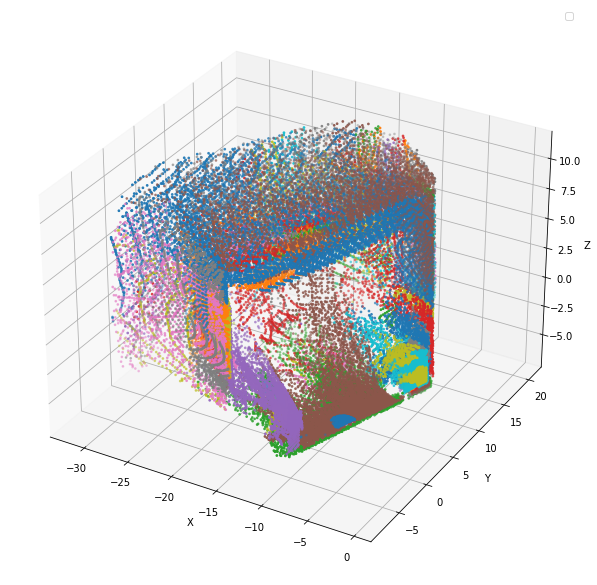

mask generation time:  0.7504417896270752
time: 73.35684895515442
(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127.]), array([7155, 1008, 5873, 1596,  964, 5122,  299,  243,  595,  283,  447,
      

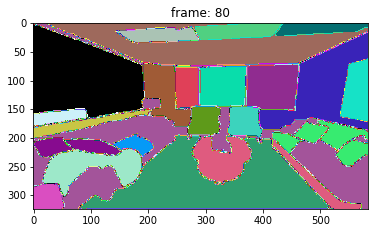

No handles with labels found to put in legend.


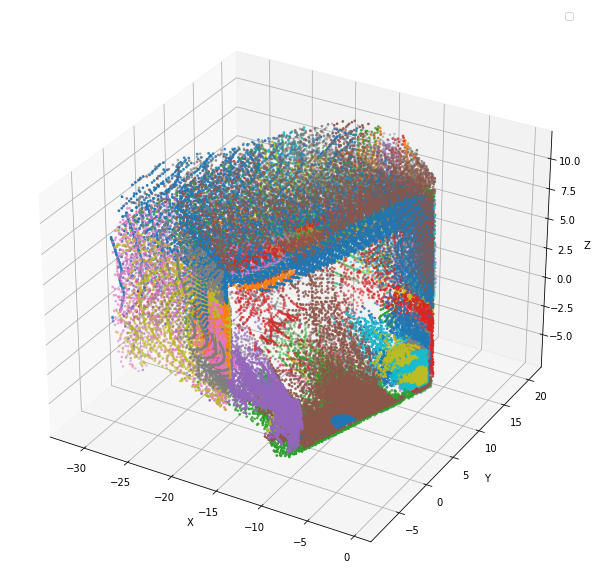

mask generation time:  0.7560207843780518
time: 92.41797089576721
(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 14

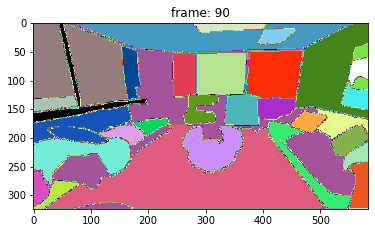

No handles with labels found to put in legend.


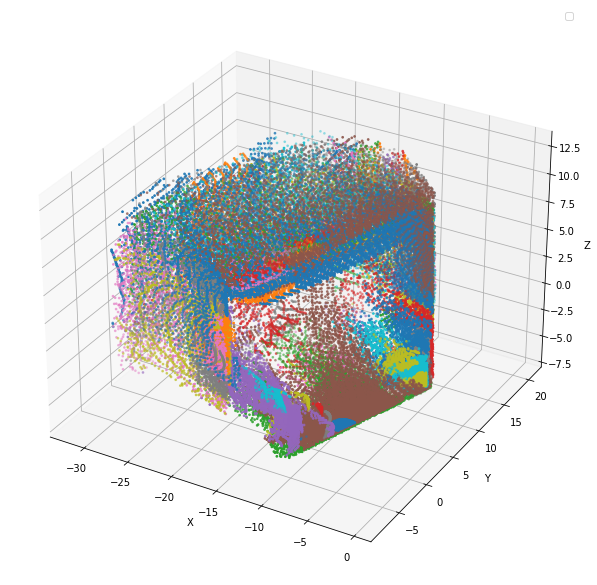

mask generation time:  0.753481388092041
time: 95.56756162643433
(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140

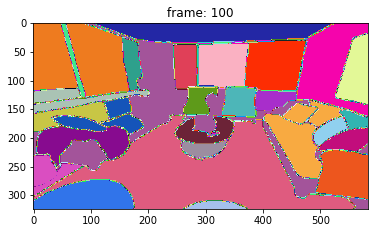

No handles with labels found to put in legend.


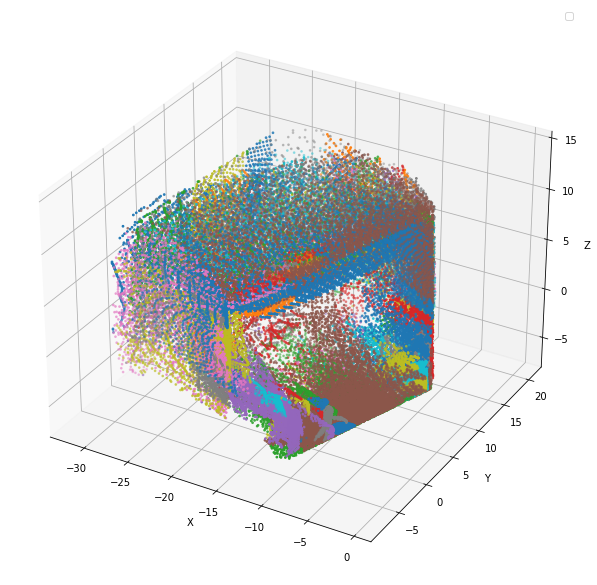

mask generation time:  0.8000600337982178
time: 114.33306360244751
(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 1

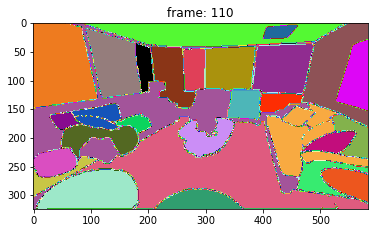

No handles with labels found to put in legend.


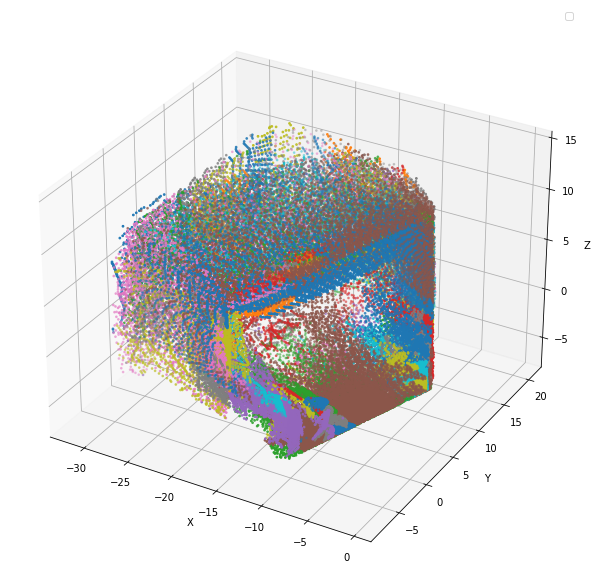

mask generation time:  0.7556064128875732


KeyboardInterrupt: 

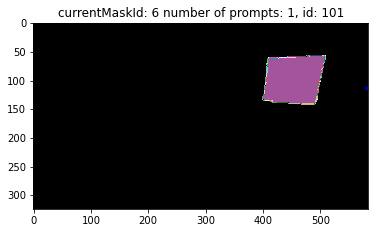

In [29]:
segmenter.runAuto()

In [ ]:
import numpy as np
import open3d as o3d
points = np.random.rand(10,3)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 2: Compute a mesh using the Ball Pivoting algorithm
# You may need to adjust the radii parameter based on the scale of your point cloud
radii = [0.005, 0.01, 0.02, 0.04]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       pcd, o3d.utility.DoubleVector(radii))

# Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

In [ ]:
frame_reader.n_img//50

48

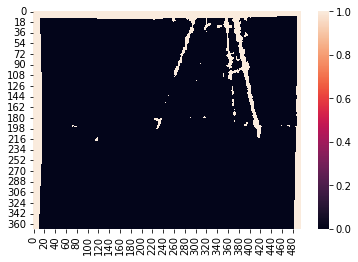

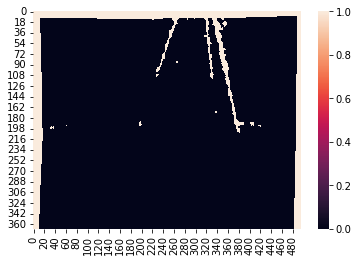

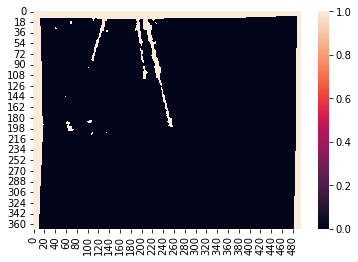

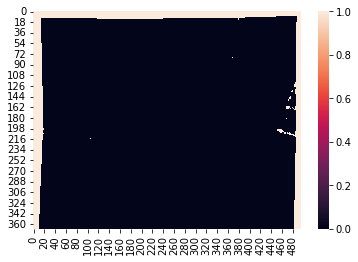

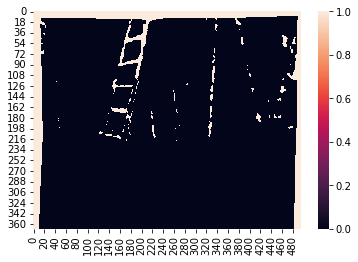

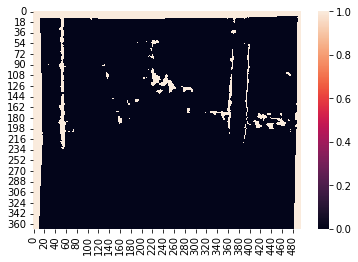

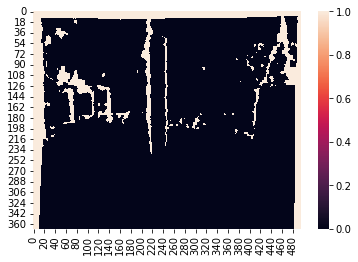

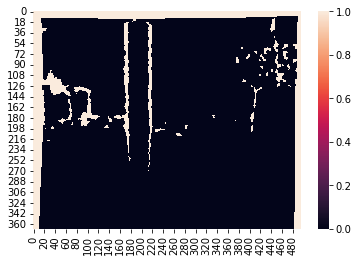

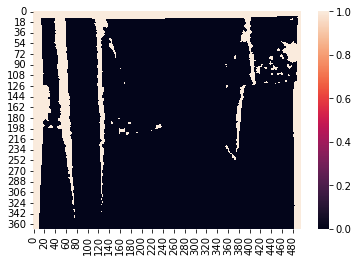

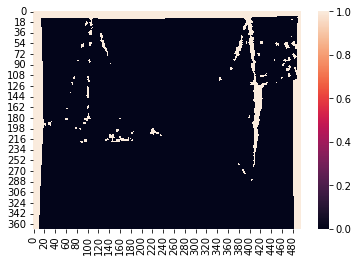

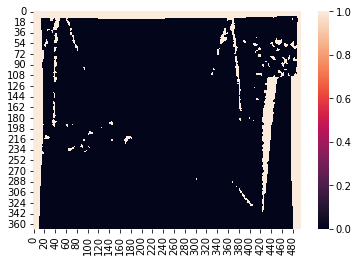

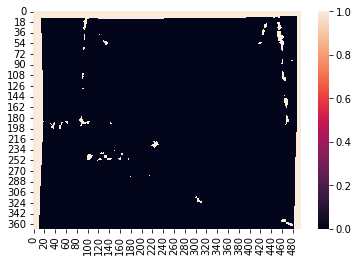

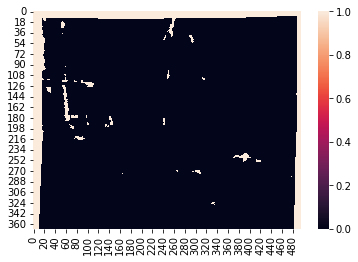

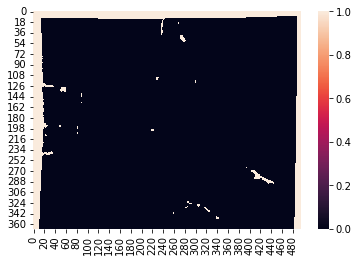

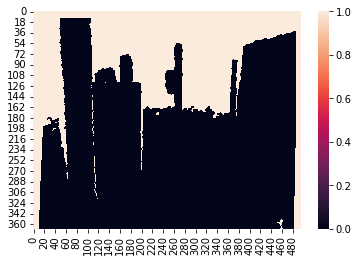

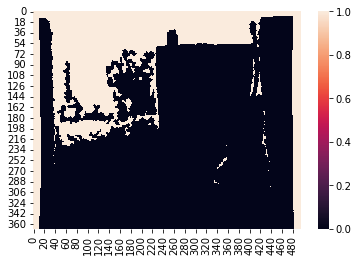

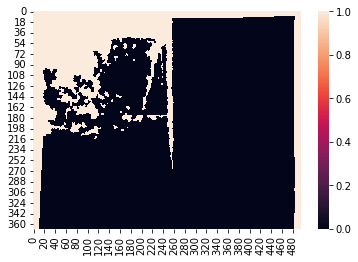

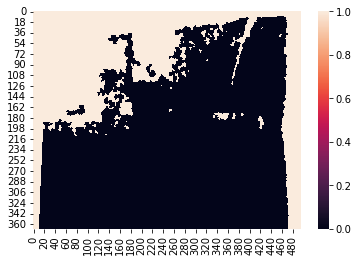

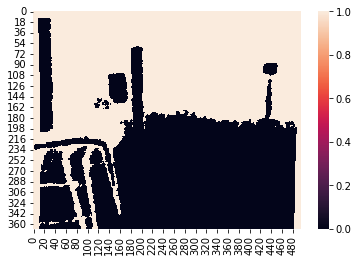

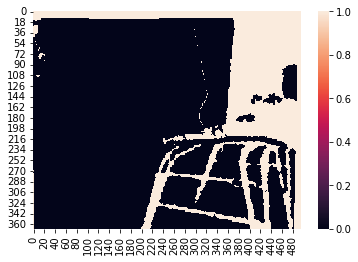

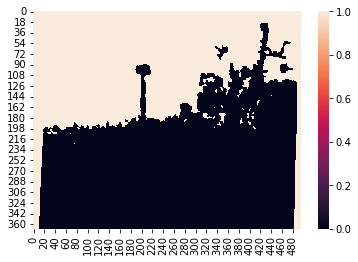

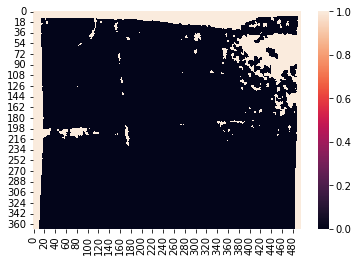

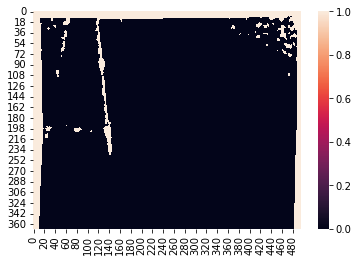

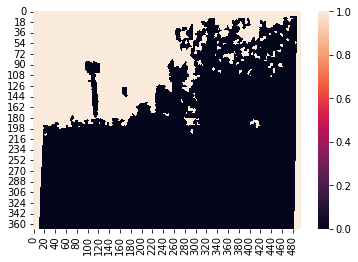

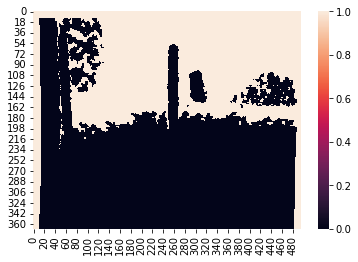

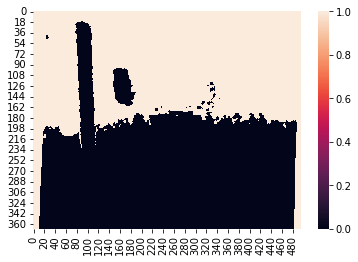

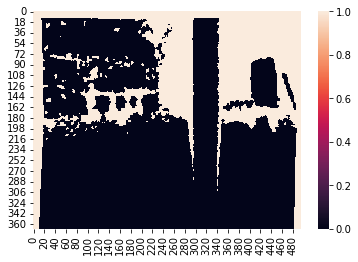

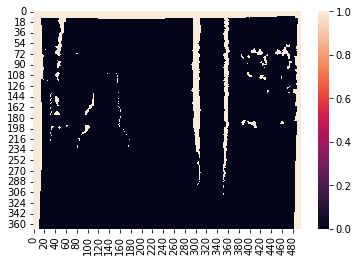

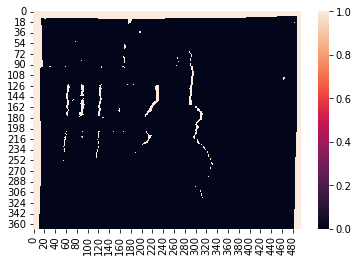

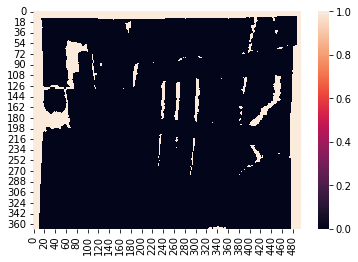

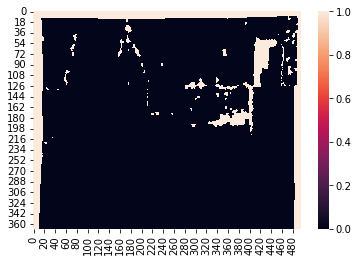

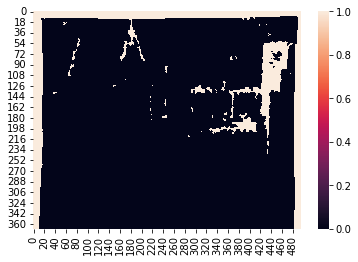

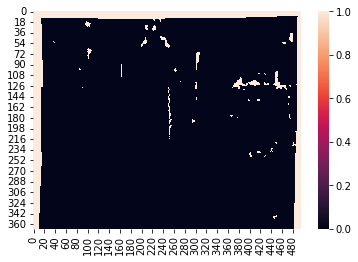

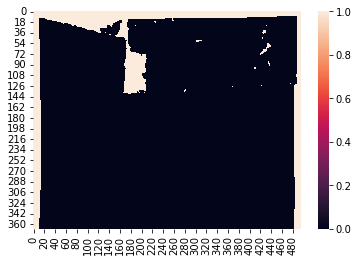

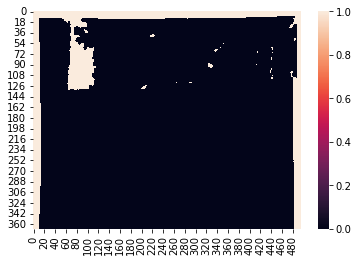

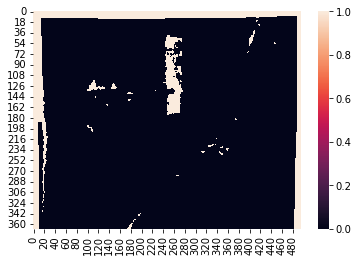

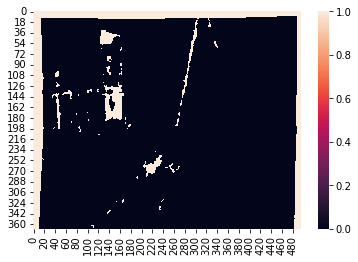

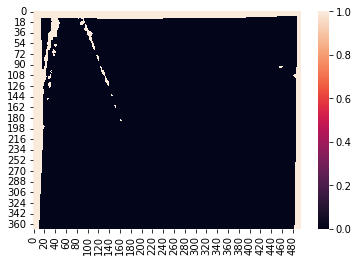

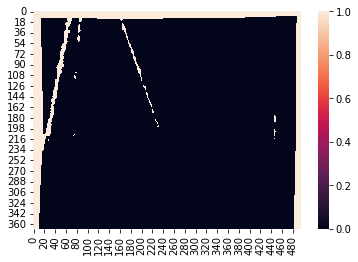

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
for idx in range(0, frame_reader.n_img, 50):
    _,_, depth,_,_ = frame_reader[idx]
    sns.heatmap(depth.cpu().numpy() == 0)
    plt.show()
    plt.clf()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


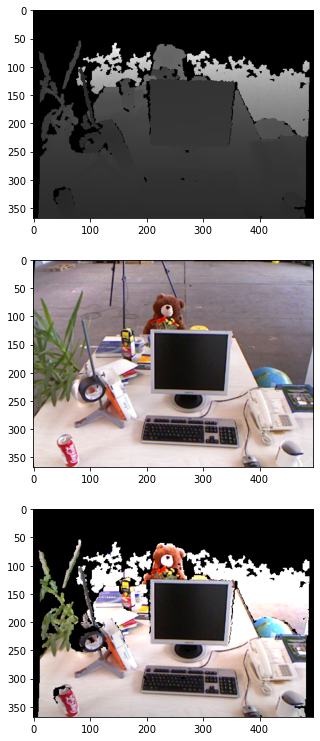

In [10]:
color, depth= frame_reader.get_colorAndDepth(1000)
#_,depth = frame_reader.get_colorAndDepth(80)
color = color.cpu().numpy()
depth = depth.cpu().numpy()
depth = depth / np.max(depth)
depth = np.stack([depth, depth, depth], axis=-1)
fig, ax = plt.subplots(3, 1, figsize=(40, 13))
ax[0].imshow(depth)
#plt.show()
ax[1].imshow(color)
#plt.show()
ax[2].imshow(color*depth*5)